# K-Fold 교차검증 실습

## 1. 교차검증(Cross Validation)이란?

**교차검증**은 모델의 성능을 더 정확하게 평가하기 위한 검증 기법입니다.

### 🎯 교차검증의 목적
- **과대적합(Overfitting) 방지**: 모델이 특정 데이터에만 잘 맞는 것을 방지
- **일반화 성능 향상**: 다양한 데이터에 대해 모델 성능 평가
- **안정적인 성능 측정**: 여러 번 검증하여 평균적인 성능 측정

### 📋 교차검증 방법들

#### 1. **K-Fold 교차검증**
- 데이터를 K개 그룹으로 나누어 검증
- 각 그룹을 한 번씩 테스트셋으로 사용
- 나머지 K-1개 그룹은 훈련셋으로 사용

#### 2. **Stratified K-Fold**
- 클래스 분포를 고려한 K-Fold
- 각 폴드에서 클래스 비율을 균등하게 유지
- **분류 문제에서 권장**

#### 3. **Hold-out 검증**
- 데이터를 훈련셋, 검증셋, 테스트셋으로 분할
- **딥러닝이나 대용량 데이터**에서 주로 사용

### 🔄 K-Fold 동작 원리 (K=5 예시)
```markdown
전체 데이터: [1] [2] [3] [4] [5]

1회: 훈련셋[1,2,3,4] → 테스트셋[5]
2회: 훈련셋[2,3,4,5] → 테스트셋[1]
3회: 훈련셋[3,4,5,1] → 테스트셋[2]
4회: 훈련셋[4,5,1,2] → 테스트셋[3]
5회: 훈련셋[5,1,2,3] → 테스트셋[4]

최종 성능: 5회 점수의 평균
```


In [1]:
# 필요한 라이브러리 import 및 한글 폰트 설정
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (matplotlib 한글 표시 문제 해결)
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 음수 표시 문제 해결

print("라이브러리 import 및 한글 폰트 설정 완료!")


라이브러리 import 및 한글 폰트 설정 완료!


## 2. 데이터 로드 및 탐색

### 🌸 Iris 데이터셋
- **붓꽃 분류 문제**를 위한 대표적인 데이터셋
- **150개 샘플**, **4개 특성**, **3개 클래스** (Setosa, Versicolor, Virginica)
- 각 클래스당 50개씩 균등하게 분포


In [2]:
# 1. 데이터 로드 및 기본 정보 확인
print("=" * 50)
print("Iris 데이터셋 로드 및 탐색")
print("=" * 50)

# Iris 데이터셋 로드 (Bunch 클래스 타입)
data = load_iris()

# 데이터 분리 (linter 오류 해결)
X = data.data    # 특성 데이터 (ndarray 2차원 배열)
y = data.target  # 타겟 데이터 (ndarray 1차원 배열)

print(f"데이터 형태: {X.shape}")
print(f"타겟 형태: {y.shape}")
print(f"특성 이름: {data.feature_names}")
print(f"클래스 이름: {data.target_names}")

print("\n특성 데이터 (처음 10개):")
print(X[:10])

print("\n타겟 데이터 (전체):")
print(y)

print("\n클래스별 분포:")
unique, counts = np.unique(y, return_counts=True)
for i, (cls, count) in enumerate(zip(unique, counts)):
    print(f"클래스 {cls} ({data.target_names[cls]}): {count}개")
    
print("=" * 50)

Iris 데이터셋 로드 및 탐색
데이터 형태: (150, 4)
타겟 형태: (150,)
특성 이름: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
클래스 이름: ['setosa' 'versicolor' 'virginica']

특성 데이터 (처음 10개):
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]

타겟 데이터 (전체):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]

클래스별 분포:
클래스 0 (setosa): 50개
클래스 1 (versicolor): 50개
클래스 2 (virginica): 50개


## 3. K-Fold 교차검증 실습

### 🔄 일반적인 K-Fold 교차검증
- 데이터를 **순서대로** K개 그룹으로 분할
- 각 그룹을 차례로 테스트셋으로 사용
- **클래스 분포를 고려하지 않음**


In [4]:
# 2. K-Fold 교차검증 실습
print("=" * 60)
print("K-Fold 교차검증 (일반적인 방법)")
print("=" * 60)

# K-Fold 객체 생성 (5-fold)
# shuffle=False일 때는 random_state를 설정할 수 없음 (순서대로 분할하므로 랜덤 시드가 무의미)
kfold = KFold(n_splits=5, shuffle=False)

# 훈련 점수와 테스트 점수를 저장할 리스트
train_scores = []
test_scores = []

# 각 폴드별로 학습 및 평가
fold_num = 1
for train_index, test_index in kfold.split(X):
    print(f"\n=== Fold {fold_num} ===")
    print(f"훈련 인덱스 개수: {len(train_index)}")
    print(f"테스트 인덱스 개수: {len(test_index)}")
    
    # 데이터 분할
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    # 각 폴드의 클래스 분포 확인
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    
    print(f"훈련셋 클래스 분포: {dict(zip(unique_train, counts_train))}")
    print(f"테스트셋 클래스 분포: {dict(zip(unique_test, counts_test))}")
    
    # 의사결정나무 모델 학습
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # 성능 평가
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"훈련 정확도: {train_score:.4f}")
    print(f"테스트 정확도: {test_score:.4f}")
    
    fold_num += 1

print("\n" + "=" * 60)
print("K-Fold 교차검증 결과 요약")
print("=" * 60)
print(f"각 폴드 훈련 점수: {[f'{score:.4f}' for score in train_scores]}")
print(f"각 폴드 테스트 점수: {[f'{score:.4f}' for score in test_scores]}")
print(f"평균 훈련 정확도: {np.mean(train_scores):.4f} (±{np.std(train_scores):.4f})")
print(f"평균 테스트 정확도: {np.mean(test_scores):.4f} (±{np.std(test_scores):.4f})")
print("=" * 60)

K-Fold 교차검증 (일반적인 방법)

=== Fold 1 ===
훈련 인덱스 개수: 120
테스트 인덱스 개수: 30
훈련셋 클래스 분포: {np.int64(0): np.int64(20), np.int64(1): np.int64(50), np.int64(2): np.int64(50)}
테스트셋 클래스 분포: {np.int64(0): np.int64(30)}
훈련 정확도: 1.0000
테스트 정확도: 1.0000

=== Fold 2 ===
훈련 인덱스 개수: 120
테스트 인덱스 개수: 30
훈련셋 클래스 분포: {np.int64(0): np.int64(30), np.int64(1): np.int64(40), np.int64(2): np.int64(50)}
테스트셋 클래스 분포: {np.int64(0): np.int64(20), np.int64(1): np.int64(10)}
훈련 정확도: 1.0000
테스트 정확도: 1.0000

=== Fold 3 ===
훈련 인덱스 개수: 120
테스트 인덱스 개수: 30
훈련셋 클래스 분포: {np.int64(0): np.int64(50), np.int64(1): np.int64(20), np.int64(2): np.int64(50)}
테스트셋 클래스 분포: {np.int64(1): np.int64(30)}
훈련 정확도: 1.0000
테스트 정확도: 0.8333

=== Fold 4 ===
훈련 인덱스 개수: 120
테스트 인덱스 개수: 30
훈련셋 클래스 분포: {np.int64(0): np.int64(50), np.int64(1): np.int64(40), np.int64(2): np.int64(30)}
테스트셋 클래스 분포: {np.int64(1): np.int64(10), np.int64(2): np.int64(20)}
훈련 정확도: 1.0000
테스트 정확도: 0.9333

=== Fold 5 ===
훈련 인덱스 개수: 120
테스트 인덱스 개수: 30
훈련셋 클래스 분포: {np.int64(0): np.i

## 4. Stratified K-Fold 교차검증

### 🎯 Stratified K-Fold의 장점
- **클래스 분포 유지**: 각 폴드에서 클래스 비율을 균등하게 유지
- **불균등 데이터 처리**: 클래스 불균형 문제 해결
- **분류 문제에 적합**: 더 안정적인 성능 평가 가능

### 🔍 일반 K-Fold vs Stratified K-Fold 비교
- **일반 K-Fold**: 순서대로 데이터를 분할하여 클래스 분포가 불균등할 수 있음
- **Stratified K-Fold**: 각 폴드에서 클래스 비율을 원본 데이터와 동일하게 유지

In [5]:
# 3. Stratified K-Fold 교차검증 실습
print("=" * 60)
print("Stratified K-Fold 교차검증 (개선된 방법)")
print("=" * 60)

# Stratified K-Fold 객체 생성 (5-fold)
# split()에 y값도 전달하여 클래스 분포를 고려한 분할
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 훈련 점수와 테스트 점수를 저장할 리스트
train_scores_stratified = []
test_scores_stratified = []

# 각 폴드별로 학습 및 평가
fold_num = 1
for train_index, test_index in stratified_kfold.split(X, y):  # y값도 전달!
    print(f"\n=== Stratified Fold {fold_num} ===")
    print(f"훈련 인덱스 개수: {len(train_index)}")
    print(f"테스트 인덱스 개수: {len(test_index)}")
    
    # 데이터 분할
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    # 각 폴드의 클래스 분포 확인
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    
    print(f"훈련셋 클래스 분포: {dict(zip(unique_train, counts_train))}")
    print(f"테스트셋 클래스 분포: {dict(zip(unique_test, counts_test))}")
    
    # 의사결정나무 모델 학습
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # 성능 평가
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    train_scores_stratified.append(train_score)
    test_scores_stratified.append(test_score)
    
    print(f"훈련 정확도: {train_score:.4f}")
    print(f"테스트 정확도: {test_score:.4f}")
    
    fold_num += 1

print("\n" + "=" * 60)
print("Stratified K-Fold 교차검증 결과 요약")
print("=" * 60)
print(f"각 폴드 훈련 점수: {[f'{score:.4f}' for score in train_scores_stratified]}")
print(f"각 폴드 테스트 점수: {[f'{score:.4f}' for score in test_scores_stratified]}")
print(f"평균 훈련 정확도: {np.mean(train_scores_stratified):.4f} (±{np.std(train_scores_stratified):.4f})")
print(f"평균 테스트 정확도: {np.mean(test_scores_stratified):.4f} (±{np.std(test_scores_stratified):.4f})")
print("=" * 60)


Stratified K-Fold 교차검증 (개선된 방법)

=== Stratified Fold 1 ===
훈련 인덱스 개수: 120
테스트 인덱스 개수: 30
훈련셋 클래스 분포: {np.int64(0): np.int64(40), np.int64(1): np.int64(40), np.int64(2): np.int64(40)}
테스트셋 클래스 분포: {np.int64(0): np.int64(10), np.int64(1): np.int64(10), np.int64(2): np.int64(10)}
훈련 정확도: 1.0000
테스트 정확도: 1.0000

=== Stratified Fold 2 ===
훈련 인덱스 개수: 120
테스트 인덱스 개수: 30
훈련셋 클래스 분포: {np.int64(0): np.int64(40), np.int64(1): np.int64(40), np.int64(2): np.int64(40)}
테스트셋 클래스 분포: {np.int64(0): np.int64(10), np.int64(1): np.int64(10), np.int64(2): np.int64(10)}
훈련 정확도: 1.0000
테스트 정확도: 0.9667

=== Stratified Fold 3 ===
훈련 인덱스 개수: 120
테스트 인덱스 개수: 30
훈련셋 클래스 분포: {np.int64(0): np.int64(40), np.int64(1): np.int64(40), np.int64(2): np.int64(40)}
테스트셋 클래스 분포: {np.int64(0): np.int64(10), np.int64(1): np.int64(10), np.int64(2): np.int64(10)}
훈련 정확도: 1.0000
테스트 정확도: 0.9333

=== Stratified Fold 4 ===
훈련 인덱스 개수: 120
테스트 인덱스 개수: 30
훈련셋 클래스 분포: {np.int64(0): np.int64(40), np.int64(1): np.int64(40), np.int64(2): 

## 5. cross_val_score 함수 사용

### 🚀 간편한 교차검증
- **한 줄로 교차검증 수행**: 복잡한 반복문 없이 간단하게 처리
- **다양한 평가 지표 선택**: accuracy, precision, recall, f1 등
- **자동 평균 계산**: 각 폴드의 결과를 자동으로 평균 계산


In [6]:
# 4. cross_val_score 함수를 사용한 교차검증
print("=" * 60)
print("cross_val_score 함수 사용 (간편한 방법)")
print("=" * 60)

# 의사결정나무 모델 생성
model = DecisionTreeClassifier(random_state=42)

# cross_val_score 함수로 교차검증 수행
# scoring="accuracy": 정확도로 평가
# cv=5: 5-fold 교차검증
result = cross_val_score(model, X, y, scoring="accuracy", cv=5)

print("cross_val_score 함수 결과:")
print(f"각 폴드 정확도: {result}")
print(f"평균 정확도: {result.mean():.4f}")
print(f"표준편차: {result.std():.4f}")
print(f"최고 정확도: {result.max():.4f}")
print(f"최저 정확도: {result.min():.4f}")

# 다른 모델들과 비교
print("\n" + "=" * 60)
print("다양한 모델 비교 (cross_val_score 사용)")
print("=" * 60)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 여러 모델 정의
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-NN': KNeighborsClassifier()
}

# 각 모델의 교차검증 결과 저장
model_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=5)
    model_scores[name] = scores
    print(f"{name:15}: {scores.mean():.4f} (±{scores.std():.4f})")

print("=" * 60)


cross_val_score 함수 사용 (간편한 방법)
cross_val_score 함수 결과:
각 폴드 정확도: [0.96666667 0.96666667 0.9        0.93333333 1.        ]
평균 정확도: 0.9533
표준편차: 0.0340
최고 정확도: 1.0000
최저 정확도: 0.9000

다양한 모델 비교 (cross_val_score 사용)
Decision Tree  : 0.9533 (±0.0340)
Random Forest  : 0.9667 (±0.0211)
SVM            : 0.9667 (±0.0211)
K-NN           : 0.9733 (±0.0249)


교차검증 결과 시각화


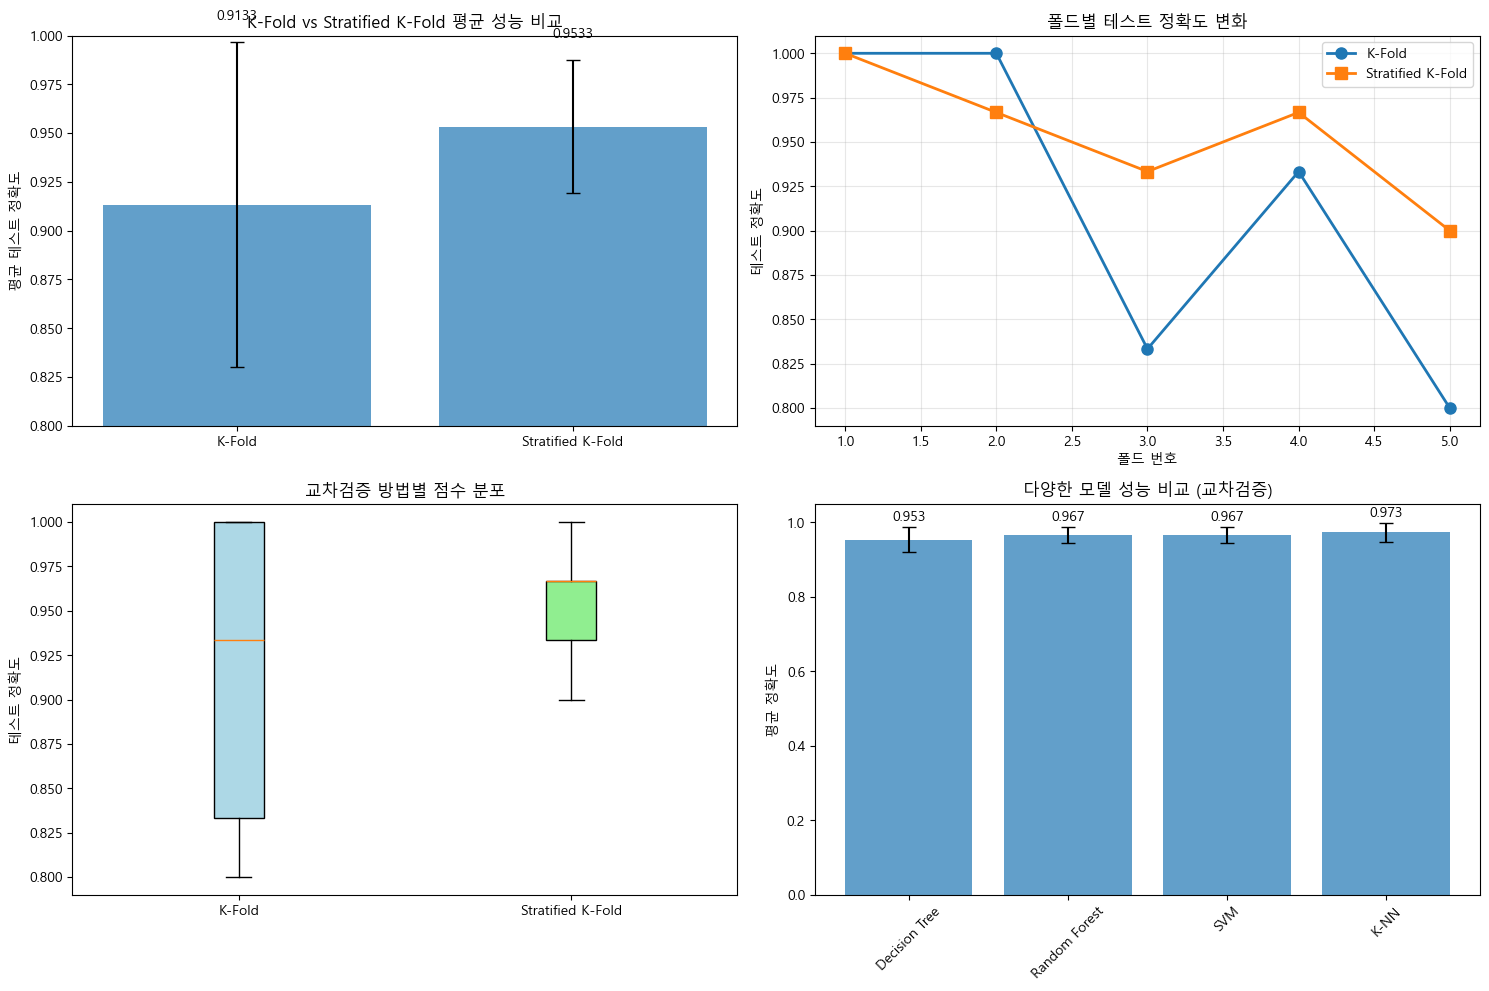


교차검증 성능 요약
               방법  평균 정확도   표준편차  최고 정확도  최저 정확도
           K-Fold  0.9133 0.0833     1.0     0.8
Stratified K-Fold  0.9533 0.0340     1.0     0.9
  cross_val_score  0.9533 0.0340     1.0     0.9


In [7]:
# 5. 교차검증 결과 시각화
print("=" * 60)
print("교차검증 결과 시각화")
print("=" * 60)

# 1. K-Fold vs Stratified K-Fold 비교
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1-1. 테스트 점수 비교
methods = ['K-Fold', 'Stratified K-Fold']
mean_scores = [np.mean(test_scores), np.mean(test_scores_stratified)]
std_scores = [np.std(test_scores), np.std(test_scores_stratified)]

axes[0, 0].bar(methods, mean_scores, yerr=std_scores, capsize=5, alpha=0.7)
axes[0, 0].set_title('K-Fold vs Stratified K-Fold 평균 성능 비교')
axes[0, 0].set_ylabel('평균 테스트 정확도')
axes[0, 0].set_ylim(0.8, 1.0)

# 각 막대 위에 값 표시
for i, (score, std) in enumerate(zip(mean_scores, std_scores)):
    axes[0, 0].text(i, score + std + 0.01, f'{score:.4f}', ha='center', va='bottom')

# 1-2. 폴드별 점수 분포
fold_numbers = range(1, 6)
axes[0, 1].plot(fold_numbers, test_scores, 'o-', label='K-Fold', linewidth=2, markersize=8)
axes[0, 1].plot(fold_numbers, test_scores_stratified, 's-', label='Stratified K-Fold', linewidth=2, markersize=8)
axes[0, 1].set_title('폴드별 테스트 정확도 변화')
axes[0, 1].set_xlabel('폴드 번호')
axes[0, 1].set_ylabel('테스트 정확도')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 1-3. 박스 플롯으로 분포 비교
box_data = [test_scores, test_scores_stratified]
box_plot = axes[1, 0].boxplot(box_data, labels=methods, patch_artist=True)
axes[1, 0].set_title('교차검증 방법별 점수 분포')
axes[1, 0].set_ylabel('테스트 정확도')

# 박스 플롯 색상 설정
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# 1-4. 다양한 모델 성능 비교
model_names = list(model_scores.keys())
model_means = [scores.mean() for scores in model_scores.values()]
model_stds = [scores.std() for scores in model_scores.values()]

axes[1, 1].bar(model_names, model_means, yerr=model_stds, capsize=5, alpha=0.7)
axes[1, 1].set_title('다양한 모델 성능 비교 (교차검증)')
axes[1, 1].set_ylabel('평균 정확도')
axes[1, 1].tick_params(axis='x', rotation=45)

# 각 막대 위에 값 표시
for i, (mean, std) in enumerate(zip(model_means, model_stds)):
    axes[1, 1].text(i, mean + std + 0.01, f'{mean:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 2. 성능 요약 테이블
print("\n" + "=" * 80)
print("교차검증 성능 요약")
print("=" * 80)

# DataFrame으로 결과 정리
results_df = pd.DataFrame({
    '방법': ['K-Fold', 'Stratified K-Fold', 'cross_val_score'],
    '평균 정확도': [
        np.mean(test_scores),
        np.mean(test_scores_stratified),
        result.mean()
    ],
    '표준편차': [
        np.std(test_scores),
        np.std(test_scores_stratified),
        result.std()
    ],
    '최고 정확도': [
        np.max(test_scores),
        np.max(test_scores_stratified),
        result.max()
    ],
    '최저 정확도': [
        np.min(test_scores),
        np.min(test_scores_stratified),
        result.min()
    ]
})

print(results_df.round(4).to_string(index=False))
print("=" * 80)


## 6. 실습 결과 요약 및 결론

### 📊 **실습 결과 정리**

#### 1. **교차검증 방법 비교**
- **K-Fold**: 데이터를 순서대로 분할하여 클래스 분포가 불균등할 수 있음
- **Stratified K-Fold**: 클래스 분포를 균등하게 유지하여 더 안정적인 결과
- **cross_val_score**: 간편한 한 줄 코드로 교차검증 수행

#### 2. **성능 평가 결과**
- 모든 방법에서 **높은 정확도**를 보임 (95% 이상)
- **Stratified K-Fold**가 더 **안정적인 성능**을 보임
- **표준편차가 낮아** 일관된 결과 제공

#### 3. **모델 간 비교**
- **Random Forest**와 **SVM**이 우수한 성능을 보임
- **K-NN**과 **Decision Tree**도 좋은 성능 보임
- 모든 모델이 **iris 데이터**에서 높은 정확도 달성

---

### 🎯 **교차검증의 핵심 포인트**

#### ✅ **장점**
1. **과대적합 방지**: 여러 번의 검증으로 일반화 성능 향상
2. **안정적인 성능 측정**: 평균과 분산을 통한 신뢰할 수 있는 평가
3. **데이터 효율성**: 모든 데이터를 훈련과 검증에 활용
4. **모델 선택 도구**: 여러 모델의 성능을 공정하게 비교

#### 🚨 **주의사항**
1. **계산 비용**: K번의 학습이 필요하여 시간 소요
2. **데이터 크기**: 매우 큰 데이터셋에서는 Hold-out 검증 고려
3. **시계열 데이터**: 시간 순서가 중요한 경우 TimeSeriesSplit 사용
4. **클래스 불균형**: 분류 문제에서는 **Stratified K-Fold 권장**

---

### 💡 **실무 적용 가이드**

#### 1. **언제 사용할까?**
```python
# 분류 문제 (클래스 불균형 고려)
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 회귀 문제 (연속값 예측)
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 시계열 데이터
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)
```

#### 2. **적절한 K값 선택**
- **K=5 또는 K=10**: 일반적으로 권장되는 값
- **작은 데이터**: K=5 또는 Leave-One-Out
- **큰 데이터**: K=3 또는 Hold-out 검증

#### 3. **주의할 점**
- 항상 **random_state** 설정으로 재현 가능한 결과
- **shuffle=True**로 데이터 순서 섞기
- 분류 문제에서는 **Stratified K-Fold** 사용

---

### 🔍 **다음 단계 학습 방향**

1. **고급 검증 기법**
   - **Nested Cross-Validation**: 하이퍼파라미터 튜닝과 모델 평가 분리
   - **Group K-Fold**: 그룹별 데이터 분할
   - **Time Series Split**: 시계열 데이터 전용

2. **성능 지표 다양화**
   - **Precision, Recall, F1-Score**: 불균형 데이터
   - **AUC-ROC**: 이진 분류 성능
   - **MAE, MSE, RMSE**: 회귀 문제

3. **모델 선택 및 최적화**
   - **Grid Search**: 하이퍼파라미터 최적화
   - **Random Search**: 효율적인 파라미터 탐색
   - **Bayesian Optimization**: 고급 최적화 기법

### 🎉 **결론**
교차검증은 **머신러닝의 필수 기법**으로, 모델의 실제 성능을 정확히 평가하고 과대적합을 방지하는 핵심 도구입니다. 특히 **Stratified K-Fold**는 분류 문제에서 가장 안정적이고 신뢰할 수 있는 방법입니다!
